In [77]:
import json
import os
import pandas as pd
import numpy as np
import collections
import re
import copy
import tensorflow as tf
import random
import cv2
import matplotlib.pyplot as plt

from transformer import PositionalEncoding
from model import ImageCaptionModel, accuracy_function, loss_function
from decoder import TransformerDecoder, RNNDecoder

In [2]:
%load_ext autoreload
%autoreload 2
import   transformer, model, decoder
%aimport transformer, model, decoder

In [3]:
root_path = './YouCookII/'
anno_path = root_path + "annotations/youcookii_annotations_trainval.json"
feat_path = root_path + 'features/feat_csv/'

feat_path_keywords = {'train': 'train_frame_feat_csv', 'val': 'val_frame_feat_csv', 'test': 'test_frame_feat_csv'}

In [4]:
f = open(anno_path, 'rb')
anno_dict = json.load(f)

In [5]:
food_types = pd.read_csv(root_path + 'label_foodtype.csv', header=None)
idx, types = food_types[0], food_types[1]
idx2type = {i: t for i, t in zip(idx, types)}

In [6]:
train_dir = feat_path + feat_path_keywords['train']
val_dir = feat_path + feat_path_keywords['val']
test_dir = feat_path + feat_path_keywords['test']

In [7]:
anno_dict['database']['0O4bxhpFX9o']

{'duration': 311.77,
 'subset': 'training',
 'recipe_type': '101',
 'annotations': [{'segment': [41, 54],
   'id': 0,
   'sentence': 'place the bacon slices on a baking pan and cook them in an oven'},
  {'segment': [84, 122],
   'id': 1,
   'sentence': 'cut the tomatoes into thin slices'},
  {'segment': [130, 135],
   'id': 2,
   'sentence': 'toast the bread slices in the toaster'},
  {'segment': [147, 190],
   'id': 3,
   'sentence': 'spread mayonnaise on the bread and place bacon slices lettuce and tomato slices on top'},
  {'segment': [192, 195], 'id': 4, 'sentence': 'top the sandwich with bread'}],
 'video_url': 'https://www.youtube.com/watch?v=0O4bxhpFX9o'}

In [8]:
def get_data(dirs):
    all_frames = []
    all_caps = []
    for dir_name in dirs:
        all_vid_names = os.listdir(dir_name)
        for vid in all_vid_names:
            if vid == '.DS_Store':
                continue
            vid_dir = dir_name + '/' + vid
            vid_feat1 = pd.read_csv(dir_name + '/' + vid + '/0001/resnet_34_feat_mscoco.csv', 
                                   header=None)
            feats = [vid_feat1]
            for vid_feat in feats:
                vid_segs = anno_dict['database'][vid]['annotations']
                vid_len = anno_dict['database'][vid]['duration']
                samp_rate = vid_len / 500
                num_segs = len(vid_segs)
                for segments in vid_segs:
                    start, end = segments['segment']
                    cap = segments['sentence']
                    start_fr = int(np.ceil(start / samp_rate))
                    end_fr = int(np.floor(end / samp_rate))
                    frame_idx = []
                    if end_fr - start_fr < 3:
                        frame_idx = list(range(start_fr, end_fr+1))
                        while len(frame_idx) < 3:
                            frame_idx += random.sample(list(range(start_fr, end_fr+1)), 1)
                    else:
                        frame_idx = random.sample(list(range(start_fr, end_fr+1)), 3)
                    for frame_num in frame_idx:
                        frame = vid_feat.iloc[frame_num]
                        all_frames.append(frame.to_numpy())
                        all_caps.append(cap)
    return np.array(all_frames), np.array(all_caps)

# Preprocessing Captions

In [9]:
window_size = 20

In [10]:
def preprocess_captions(captions, window_size):
    caps_ret = []
    for i, caption in enumerate(captions):
        # Taken from:
        # https://towardsdatascience.com/image-captions-with-attention-in-tensorflow-step-by-step-927dad3569fa

        # Convert the caption to lowercase, and then remove all special characters from it
        # caption_nopunct = re.sub(r"[^a-zA-Z0-9]+", ' ', caption.lower())
        # TODO: this step can be handled with keras tokenizer?

        # Split the caption into separate words, and collect all words which are more than 
        # one character and which contain only alphabets (ie. discard words with mixed alpha-numerics)
        clean_words = []
        for word in caption.split():
            if word.isalpha():
                clean_words.append(word)
            elif word.isnumeric():
                clean_words.append('<num>')

        # Join those words into a string
        caption_new = ['<start>'] + clean_words[:window_size-1] + ['<end>']

        # Replace the old caption in the captions list with this new cleaned caption
        caps_ret.append(caption_new)
    return caps_ret

In [11]:
def build_vocab(captions, vocab_size):
    word_count = collections.Counter()
    for caption in captions:
        word_count.update(caption)
    
    vocab = [word for word, count in word_count.most_common(vocab_size)]
    return vocab

In [12]:
def unk_captions(captions, vocab):
    temp = copy.deepcopy(captions)
    for caption in temp:
        for index, word in enumerate(caption):
            if word not in vocab:
                caption[index] = '<unk>'
    return temp

In [13]:
def pad_captions(captions, window_size):
    pad_cap = copy.deepcopy(captions)
    for caption in pad_cap:
        caption += (window_size + 1 - len(caption)) * ['<pad>']
    return pad_cap

In [14]:
def preproc_all(captions_train, captions_test, window_size):
    clean_caps_train = preprocess_captions(captions_train, window_size)
    clean_caps_test = preprocess_captions(captions_test, window_size)
    
    vocab = build_vocab(clean_caps_train, 1800)
    
    masked_caps_train = unk_captions(clean_caps_train, vocab)
    masked_caps_test = unk_captions(clean_caps_test, vocab)
    
    padded_caps_train = pad_captions(masked_caps_train, window_size)
    padded_caps_test = pad_captions(masked_caps_test, window_size)
    
    word2idx = {}
    vocab_size = 0
    for caption in padded_caps_train:
        for index, word in enumerate(caption):
            if word in word2idx:
                caption[index] = word2idx[word]
            else:
                word2idx[word] = vocab_size
                caption[index] = vocab_size
                vocab_size += 1
    for caption in padded_caps_test:
        for index, word in enumerate(caption):
            caption[index] = word2idx[word] 
    
    return np.array(padded_caps_train), np.array(padded_caps_test), word2idx

In [15]:
train_subdir = os.listdir(train_dir)
train_subdir.remove('.DS_Store')
train_paths = [os.path.join(train_dir, subdir) for subdir in train_subdir]
val_paths = [os.path.join(val_dir, subdir) for subdir in train_subdir]

In [16]:
train_frames, train_caps = get_data(train_paths)
val_frames, val_caps = get_data(val_paths)

In [17]:
train_caps_token, val_caps_token, word2idx = preproc_all(train_caps, val_caps, window_size)

In [18]:
print(train_caps.shape, val_caps.shape)
print(train_caps_token.shape, val_caps_token.shape)

(31011,) (10476,)
(31011, 21) (10476, 21)


In [109]:
def train_model(train, word2idx, epochs, batch_size, hidden_size, window_size, valid=None):

    decoder = TransformerDecoder(
        vocab_size  = len(word2idx), 
        hidden_size = hidden_size, 
        window_size = window_size
    )

    model = ImageCaptionModel(decoder)

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
    model.compile(
        optimizer   = optimizer,
        loss        = loss_function,
        metrics     = [accuracy_function]
    )

    train_stats = []
    valid_stats = []
    for epoch in range(epochs):
        result = model.train(train[0], train[1], word2idx['<pad>'], batch_size=batch_size)
#         print(result)
        train_stats += [result]
        if valid:
            vresult = model.test(valid[0], valid[1], word2idx['<pad>'], batch_size=batch_size)
            valid_stats += [vresult]
    return model, train_stats, valid_stats

In [110]:
model, tr_stats, v_stats = train_model((train_caps_token, train_frames), 
                    word2idx, 
                    epochs=5,
                    batch_size=300, 
                    hidden_size=128, 
                    window_size=window_size, 
                    valid=(val_caps_token, val_frames))

[Valid 34/34]	 loss=3.405	 acc: 0.332	 perp: 30.10694
[Valid 34/34]	 loss=3.203	 acc: 0.354	 perp: 24.60830
[Valid 34/34]	 loss=3.152	 acc: 0.358	 perp: 23.39217
[Valid 34/34]	 loss=3.188	 acc: 0.359	 perp: 24.24493
[Valid 34/34]	 loss=3.226	 acc: 0.359	 perp: 25.17099


In [22]:
train_frames.shape

(31011, 512)

In [23]:
def gen_caption_temperature(model, image_embedding, wordToIds, padID, temp, window_length):
    """
    Function used to generate a caption using an ImageCaptionModel given
    an image embedding. 
    """
    idsToWords = {id: word for word, id in wordToIds.items()}
    unk_token = wordToIds['<unk>']
    caption_so_far = [wordToIds['<start>']]
    while len(caption_so_far) < window_length and caption_so_far[-1] != wordToIds['<end>']:
        caption_input = np.array([caption_so_far + ((window_length - len(caption_so_far)) * [padID])])
        logits = model(np.expand_dims(image_embedding, 0), caption_input)
        logits = logits[0][len(caption_so_far) - 1]
        probs = tf.nn.softmax(logits / temp).numpy()
        next_token = unk_token
        attempts = 0
        while next_token == unk_token and attempts < 5:
            next_token = np.random.choice(len(probs), p=probs)
            attempts += 1
        caption_so_far.append(next_token)
    return ' '.join([idsToWords[x] for x in caption_so_far][1:-1])

temperature = .05
for i in range(10):
    print(gen_caption_temperature(model, val_frames[i], word2idx, word2idx['<pad>'], temperature, window_size))

place the sushi rice on the grill
add the foie gras on the pan
place the nori sheet down and place on the nori
place the sheet from the sheet
add some salt and pepper to the bread
place the sheet from the rice
cut the salmon into small pieces
add the rice noodles and mix
place the roll the roll
add some salt and pepper


In [24]:
val_caps[:10]

array(['place a sushi seaweed on the bamboo mat',
       'place a sushi seaweed on the bamboo mat',
       'place a sushi seaweed on the bamboo mat',
       'spread some sushi rice on top of the seaweed',
       'spread some sushi rice on top of the seaweed',
       'spread some sushi rice on top of the seaweed',
       'put mayonnaise fish roe crab meat red lettuce cucumber salmon and avocado on top',
       'put mayonnaise fish roe crab meat red lettuce cucumber salmon and avocado on top',
       'put mayonnaise fish roe crab meat red lettuce cucumber salmon and avocado on top',
       'hold the ingredients and roll them up with the mat'],
      dtype='<U201')

In [38]:
test_dur = pd.read_csv('./YouCookII/splits/test_duration_totalframe.csv')

In [43]:
test_dur[test_dur['vid_id'] == 'YSes0R7EksY']

,vid_id,duration,total_frame
47,YSes0R7EksY,449.7,11242


In [66]:
fps = 500 / 449.7
frame_num = int(304 * fps)

In [67]:
test_feat = pd.read_csv('./YouCookII/features/feat_csv/test_frame_feat_csv/101/YSes0R7EksY/0001/resnet_34_feat_mscoco.csv', header=None)

In [68]:
z = test_feat.iloc[frame_num]

In [73]:
generated_cap = gen_caption_temperature(model, z, word2idx, word2idx['<pad>'], temperature, window_size)

In [71]:
def get_frame(vid_path, vid_name, seconds):
    cap = cv2.VideoCapture(os.path.join(vid_path, vid_name))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_id = int(fps * seconds)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    res, frame = cap.read()
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

In [75]:
test_image = get_frame('./YouCookII/raw_videos/testing/101', 'YSes0R7EksY', 304)

(-0.5, 1279.5, 719.5, -0.5)

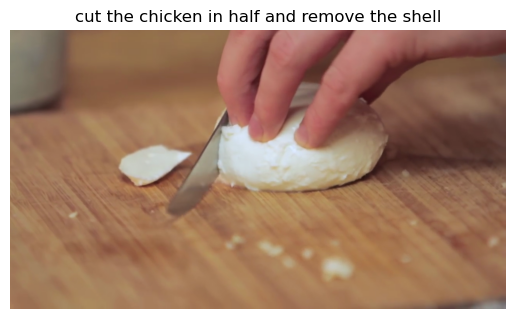

In [79]:
plt.imshow(test_image)
plt.title(generated_cap)
plt.axis('off')

In [117]:
train_losses, train_accuracy, train_perplexity = [], [], []
val_losses, val_accuracy, val_perplexity = [], [], []
for loss, acc, perp in tr_stats:
    train_losses.append(loss)
    train_accuracy.append(acc)
    train_perplexity.append(perp)
    
for loss, acc, perp in v_stats:
    val_losses.append(loss)
    val_accuracy.append(acc)
    val_perplexity.append(perp)

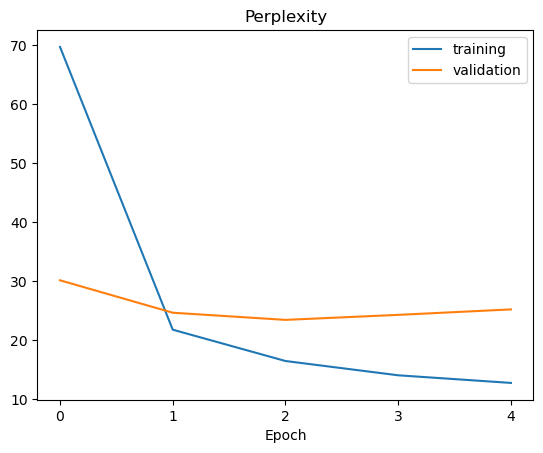

In [121]:
# plt.plot(losses)
# plt.plot(accuracy)
plt.plot(train_perplexity, label='training')
plt.plot(val_perplexity, label='validation')
plt.title('Perplexity')
plt.xlabel('Epoch')
plt.xticks(list(range(5)))
plt.legend()

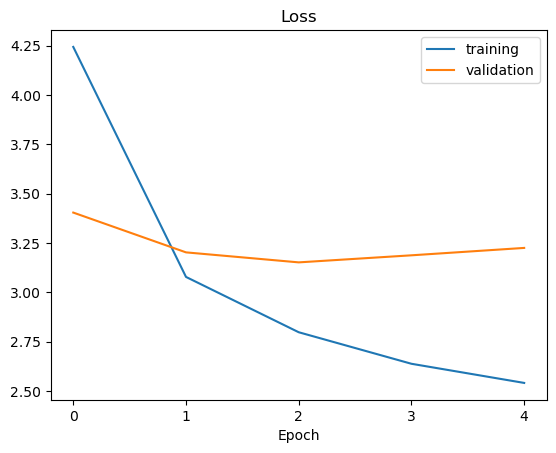

In [124]:
plt.plot(train_losses, label='training')
plt.plot(val_losses, label='validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.xticks(list(range(5)))
plt.legend()